## Run SimSS simulations and plot the results
Version 0.1
(c) Vincent M. Le Corre (https://github.com/VMLC-PV)

In [1]:
# Package import
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook
# comment the above line if you don't want interactive plots
import os,platform,warnings
import numpy as np
import pandas as pd
from scipy.stats import loguniform
import matplotlib.pyplot as plt
# Import homemade package by VLC
# from SIMsalabim_utils.RunSim import PrepareSimuInputs, RunSimulation # Run simulation
# from SIMsalabim_utils.SimSS_plots import PlotJV, PlotJVPerf,PlotNrjDiagSimSS,PlotDensSimSS # Plotting functions
# from SIMsalabim_utils.CleanFolder import clean_up_output, clean_file_type # Cleaning functions
# from SIMsalabim_utils import plot_settings_screen # Plot settings
from boar import *
from boar.SIMsalabim_utils.SimSS_plots import *
from boar.SIMsalabim_utils.aux_func import *
## General Inputs
warnings.filterwarnings("ignore")           # Don't show warnings

max_jobs = 100
number_students = 30
# Path to SIMsalabim
curr_dir = os.path.abspath(os.getcwd())
path2simu = os.path.join(curr_dir ,'SIMsalabim','SimSS')
path2dev = os.path.join(curr_dir,'Example_Data','Data_test','device_parameters_fake_OPV.txt')


In [2]:
case = 'Case_5'
Gehp_min = 1.25e28
Gehp_max = 1.3e28
Nc_min = 1e26
Nc_max = 5e26
kdirect_min = 1e-18
kdirect_max = 1e-17
Rseries_min = 1e-5
Rseries_max = 1e-3
Rshunt_min = 1e-2
Rshunt_max = 1e1

In [3]:
# Prepare the command strings to run
fixed_str = path2dev+ ' '
parameters = []
Gehp = list(loguniform.rvs(Gehp_min,Gehp_max,size=number_students))
parameters.append({'name':'Gehp','values':Gehp})
Nc = list(loguniform.rvs(Nc_min,Nc_max,size=number_students))
parameters.append({'name':'Nc','values':Nc})
kdirect = list(loguniform.rvs(kdirect_min,kdirect_max,size=number_students))
parameters.append({'name':'kdirect','values':kdirect})
Rseries = list(loguniform.rvs(Rseries_min,Rseries_max,size=number_students))
parameters.append({'name':'Rseries','values':Rseries})
Rshunt = list(loguniform.rvs(Rshunt_min,Rshunt_max,size=number_students))
parameters.append({'name':'Rshunt','values':Rshunt})

Simulation_Inputs = DegradationPrepareSimuInputs(path2simu,parameters=parameters,fixed_str=fixed_str,CodeName = 'SimSS',verbose=True) # creates all necessary list inputs

RunSimulation(Simulation_Inputs,max_jobs=max_jobs,do_multiprocessing=True,verbose=False) # runs the simulations


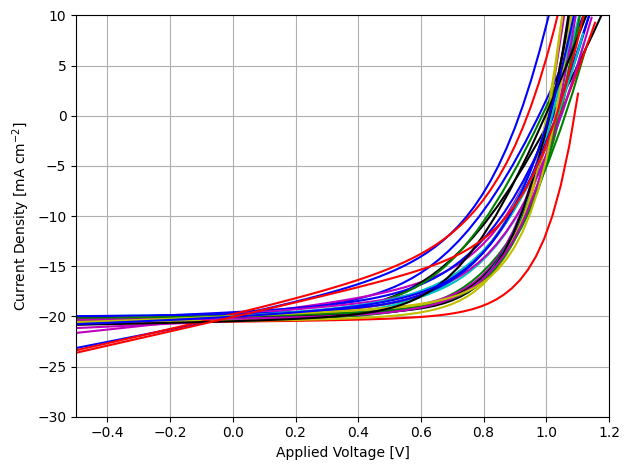

In [4]:
# Make JV plots
str_lst,JV_files,Var_files,scPars_files,code_name_lst,path_lst,labels = Simulation_Inputs
colors = [] # prepare color for plots

PlotJV(JV_files, labels=labels,colors=colors,num_fig=0,plot_type=0,x='Vext',y=['Jext'],legend=False,xlimits=[-0.5,1.2],ylimits=[-30,1e1],x_unit='V',y_unit='mA/cm^2',save_fig=True,fig_name=os.path.join(path2simu,'JV.png'),mark='',line_type = ['-'])


In [5]:
# Create a folder to store the results
path2results = os.path.join(curr_dir,'Data_2_fit',case)
if not os.path.exists(path2results):
    os.mkdir(path2results)

for idx,jv in enumerate(JV_files):
    data = pd.read_csv(jv,delim_whitespace=True)

    Jsc = get_Jsc(data['Vext'], data['Jext'])
    
    data = data[data['Jext'] < abs(Jsc)]

    # only keep Vext > -0.1
    data = data[data['Vext'] > -0.1]

    #save only 'Vext' and 'Jext' columns to a new file
    data[['Vext', 'Jext']].to_csv(os.path.join(path2results, case+f'_student_{idx+1}.txt'), sep=' ', index=False)



In [6]:
# saved simulated parameters in a file
df = pd.DataFrame({'student':np.arange(1,number_students+1)})

for idx,par in enumerate(parameters):
    df[par['name']] = par['values']


# save as excel file
df.to_excel(os.path.join(curr_dir, case+'_parameters.xlsx'), index=False)



In [7]:
# make a copy of the device parameters file in case folder
import shutil
shutil.copy(path2dev, os.path.join(path2results, case+'_device_parameters.txt'))

'/home/vlc/Desktop/PV_system_lecture/Data_2_fit/Case_5/Case_5_device_parameters.txt'

In [8]:
# Clean output files from simulation folders
Do_Cleaning = False # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('log',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('joblog',path2simu)
    clean_file_type('.jpg',path2simu) # clean all jpg files
    clean_file_type('.png',path2simu) # clean all png files
    